In [1]:
%pylab inline
import scipy, scipy.misc, scipy.stats

Populating the interactive namespace from numpy and matplotlib


Some basic formulas and definitions:
- MTBF = mean time between failures (time unit T per failure)
- &lambda; = failures per time unit T (mean over many identical components)
- F = failure rate or probability of failure in time unit T
- R = reliability rate (probability of working in time unit T)

Convertions:

- $\lambda = T / MTFB$
- $F = \lambda / T = 1 / MTBF$
- $R = 1 - F$

T is the time unit over which we calculate, usually years.

E.g.: if component has 0.5 failures per 10 years, then $\lambda = 0.05, MTBF = 20 \mathrm{Years}, F = 0.05, R = 0.95$

That is, the probably of failure within one year is 0.05.

In [3]:
def r_to_mtbf(r):
    return 1 / (1 - r)

## Serial reliability

For components connected in series, that is, a single failure can take out the system, the total reliability of the system is:

$\lambda_{total} = \sum_i \lambda_i , R_{total} = \prod_{i} R_i$

This means that $R_{total} < min(R_i)$ Total reliability is _lower_ then the reliability of the worst component. 

Suppose we have a 3 components system with reliabilities $R_1 = 0.95, R_2 = 0.99 R_3 = 0.995$; The overall reliability of the system is $R_{total} = 0.9357975$ which is indeed worse the 0.95, the reliabiliy of $R_1$ our worst component. Now, which component should we invest in? suppose we can improve reduce the failure rate of single component by a factor of 10 at equal cost, which shall we choose?

|improved|R1|R2|R3|Rtotal|improvement factor|
|-|-|-|-|-|
|-|0.95|0.99|0.995|0.9357975|-|
|R1|0.995|0.99|0.995|0.98012475|3.21x|
|R2|0.95|0.999|0.995|0.94430475|1.15x|
|R3|0.95|0.99|0.9995|0.94|1.07x|

We can see that the best ROI comes from improving the worst component and that improving the most reliable component achieves almost nothing.

## Parallel reliability (redundancy)

The reliability of a parallel system can be computed by the formula:
$R_{total} = \sum_{i=0}^{k} \binom{n}{k} R^{i} F^{n-i}$

For simplicity we assume identical components.


It's important to note that &lambda; is a statistical mean (average) of failures of many components; If you operate a single such component with $F = 0.05$ for 10 years you may have 0 failures or a failure within the first year; in fact, there's a $0.95^{10} \approx 0.6$ chance of a component surviving 10 years. 
Over _n_ components, the of probability of having _k_ failures follows a binomial distribution. 

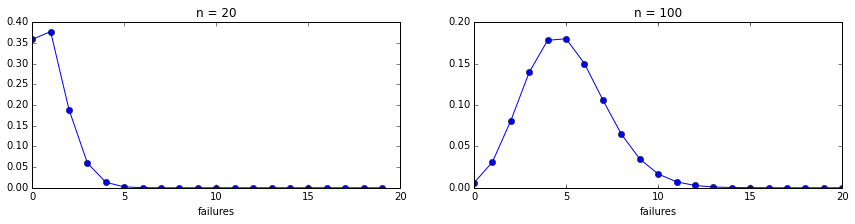

In [64]:
n_components1, n_components2 = 20, 100
f = 0.05
k_failures_vec1 = arange(0, n_components1, 1)
k_failures_vec2 = arange(0, n_components2, 1)

pmf1 = scipy.stats.binom.pmf(k_failures_vec1, n_components1, f)
pmf2 = scipy.stats.binom.pmf(k_failures_vec2, n_components2, f)
ax1 = plt.subplot(121)
ax1.set_xlabel('failures')
plt.title('Probability mass function (binomial)')
ax1.plot(k_failures_vec, pmf, marker='o')
ax1.set_title('n = 20')
ax2 = plt.subplot(122)
ax2.set_xlabel('failures')
ax2.set_xticks(arange(0, 100, 5), minor=True)
ax2.plot(k_failures_vec2, pmf2, marker='o')
ax2.set_title('n = 100')
ax2.set_xlim(0, 20)
plt.subplots_adjust(top=0.7, right=2)

That is, over many systems composed of _n_ components with $F = 0.05$ many (~ 40%) will have 1 failure per year, about 18% will have 2 failures and so on. This shows that with more components we have higher chance of multiple failures. Which is why systems with more components need to be more redundant in absolute numbers.  

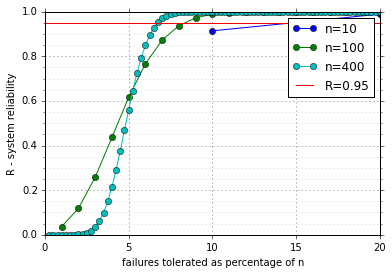

In [65]:
def r_prob(r, n, k):
    """The reliability of parallel system with n component that can tolerate up to k failures
    """
    return sum([scipy.misc.comb(n, i)*(1-r)**i*r**(n-i) for i in range(0,k+1)])

vec_r_prob = np.vectorize(r_prob)

ax = plt.subplot(111)
r = 0.95

for n, color in [(10, 'b'), (100, 'g'), (400, 'c')]:
    x = np.linspace(1, n, n, dtype='int')
    ax.plot(x / float(n) * 100, vec_r_prob(r, n, x), label='n=%d' % n, color=color, marker='o')

# plot formatting stuff, not really interesting
ax.axhline(r, color='r', label='R=%0.2f' % r)
ax.legend()
ax.set_xlabel('failures tolerated as percentage of n')
ax.set_ylabel('R - system reliability')
ax.set_yticks(np.arange(0, 1.2, 0.2))
ax.set_yticks(np.arange(0, 1.05, 0.05), minor=True)
ax.set_xticks(np.arange(0, 101, 5), minor=True)
ax.tick_params(which = 'both', direction = 'out')
ax.set_ylim(0, 1.0)
ax.set_xlim(0, 20)
ax.grid(which='major', alpha=0.7)
ax.grid(which='minor', alpha=0.3)

From the above graph we can see that as n grows we need smaller redundancy to achieve the same reliability. With 10 machines we need 20% redundancy to be more reliable than a single node, with 100 only 9% and with 400 nodes only 6% redudancy.
We can also see that with small redudancy reliability actually *decreases*, because there are more options for failure.

In [5]:
for r, n, k in [(0.95, 10, 2), (0.99, 10, 2)]:
    r_total = r_prob(r, n, k)
    print "r_comp=%.2f, mtbf_comp=%d, r_total=%.4f, mtbf_total=%d" % (r, r_to_mtbf(r), r_total, r_to_mtbf(r_total))


r_comp=0.95, mtbf_comp=19, r_total=0.9885, mtbf_total=86
r_comp=0.99, mtbf_comp=99, r_total=0.9999, mtbf_total=8783


From this we see that redundancy acts as a multiplier on component MTBF - improving component MTBF by a factor of 5 improves total MTBF by a factor of 100!
So redudancy will have higher ROI if your components are already reliable.